In [2]:
#Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, auc

In [3]:
#Loading image files to work with from working folder
def load_images(image_folder, img_size=(1024, 1024), convert_gray=False):
    images, file_names = [], []
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(image_folder, filename)
            image = Image.open(img_path)
            if convert_gray:
                image = image.convert("L")  # Convert to grayscale
            image = image.resize(img_size)
            images.append(np.array(image) / 255.0)  # Normalize
            file_names.append(filename)
    return images, file_names

In [4]:
#Defining a function tha calculate AUC metrics using pred saliency maps and ground saliency maps
def compute_auc_metrics(pred_saliency, gt_saliency, all_gt_saliency):
    pred_flat = pred_saliency.flatten()
    gt_flat = (gt_saliency.flatten() > 0).astype(int)
    fpr_j, tpr_j, _ = roc_curve(gt_flat, pred_flat)
    auc_judd = auc(fpr_j, tpr_j)
    num_fix = np.sum(gt_flat)
    rand_fix = np.zeros_like(gt_flat)
    rand_indices = np.random.choice(len(rand_fix), size=int(num_fix), replace=False)
    rand_fix[rand_indices] = 1
    fpr_b, tpr_b, _ = roc_curve(rand_fix, pred_flat)
    auc_borji = auc(fpr_b, tpr_b)
    
    if len(all_gt_saliency) > 1:
        shuffled_fixations = np.mean([f for f in all_gt_saliency if not np.array_equal(f, gt_saliency)], axis=0)
        shuffled_fixations = (shuffled_fixations > 0).astype(int)
        if np.sum(shuffled_fixations) > 0:
            fpr_s, tpr_s, _ = roc_curve(shuffled_fixations.flatten(), pred_flat)
            auc_shuffled = auc(fpr_s, tpr_s)
        else:
            auc_shuffled, fpr_s, tpr_s = np.nan, None, None
    else:
        auc_shuffled, fpr_s, tpr_s = np.nan, None, None
    
    return auc_judd, auc_borji, auc_shuffled, (fpr_j, tpr_j, fpr_b, tpr_b, fpr_s, tpr_s)

In [5]:
# Define folder paths
raw_image_folder = "Stimuli"
pred_saliency_folder = "Salicon_saliencymaps"
gt_saliency_folder = "GTSaliencymaps"

In [6]:
# Code to load the images and ensure all file names are consistent from stimuli to predicted saliency maps
raw_images, raw_filenames = load_images(raw_image_folder, convert_gray=False)
pred_saliency_maps, pred_filenames = load_images(pred_saliency_folder, convert_gray=True)
gt_saliency_maps, gt_filenames = load_images(gt_saliency_folder, convert_gray=True)


file_intersection = set(pred_filenames) & set(gt_filenames) & set(raw_filenames)
if not file_intersection:
    raise ValueError("No matching filenames between raw images, predicted, and ground truth saliency maps!")

file_names = sorted(file_intersection)
raw_images = [raw_images[raw_filenames.index(f)] for f in file_names]
pred_saliency_maps = [pred_saliency_maps[pred_filenames.index(f)] for f in file_names]
gt_saliency_maps = [gt_saliency_maps[gt_filenames.index(f)] for f in file_names]

In [7]:
# Actual Computation of  AUC metrics
results = []
for i, (pred_saliency, gt_saliency) in enumerate(zip(pred_saliency_maps, gt_saliency_maps)):
    auc_judd, auc_borji, auc_shuffled, rocs = compute_auc_metrics(pred_saliency, gt_saliency, gt_saliency_maps)
    results.append((file_names[i], auc_judd, auc_borji, auc_shuffled, rocs))

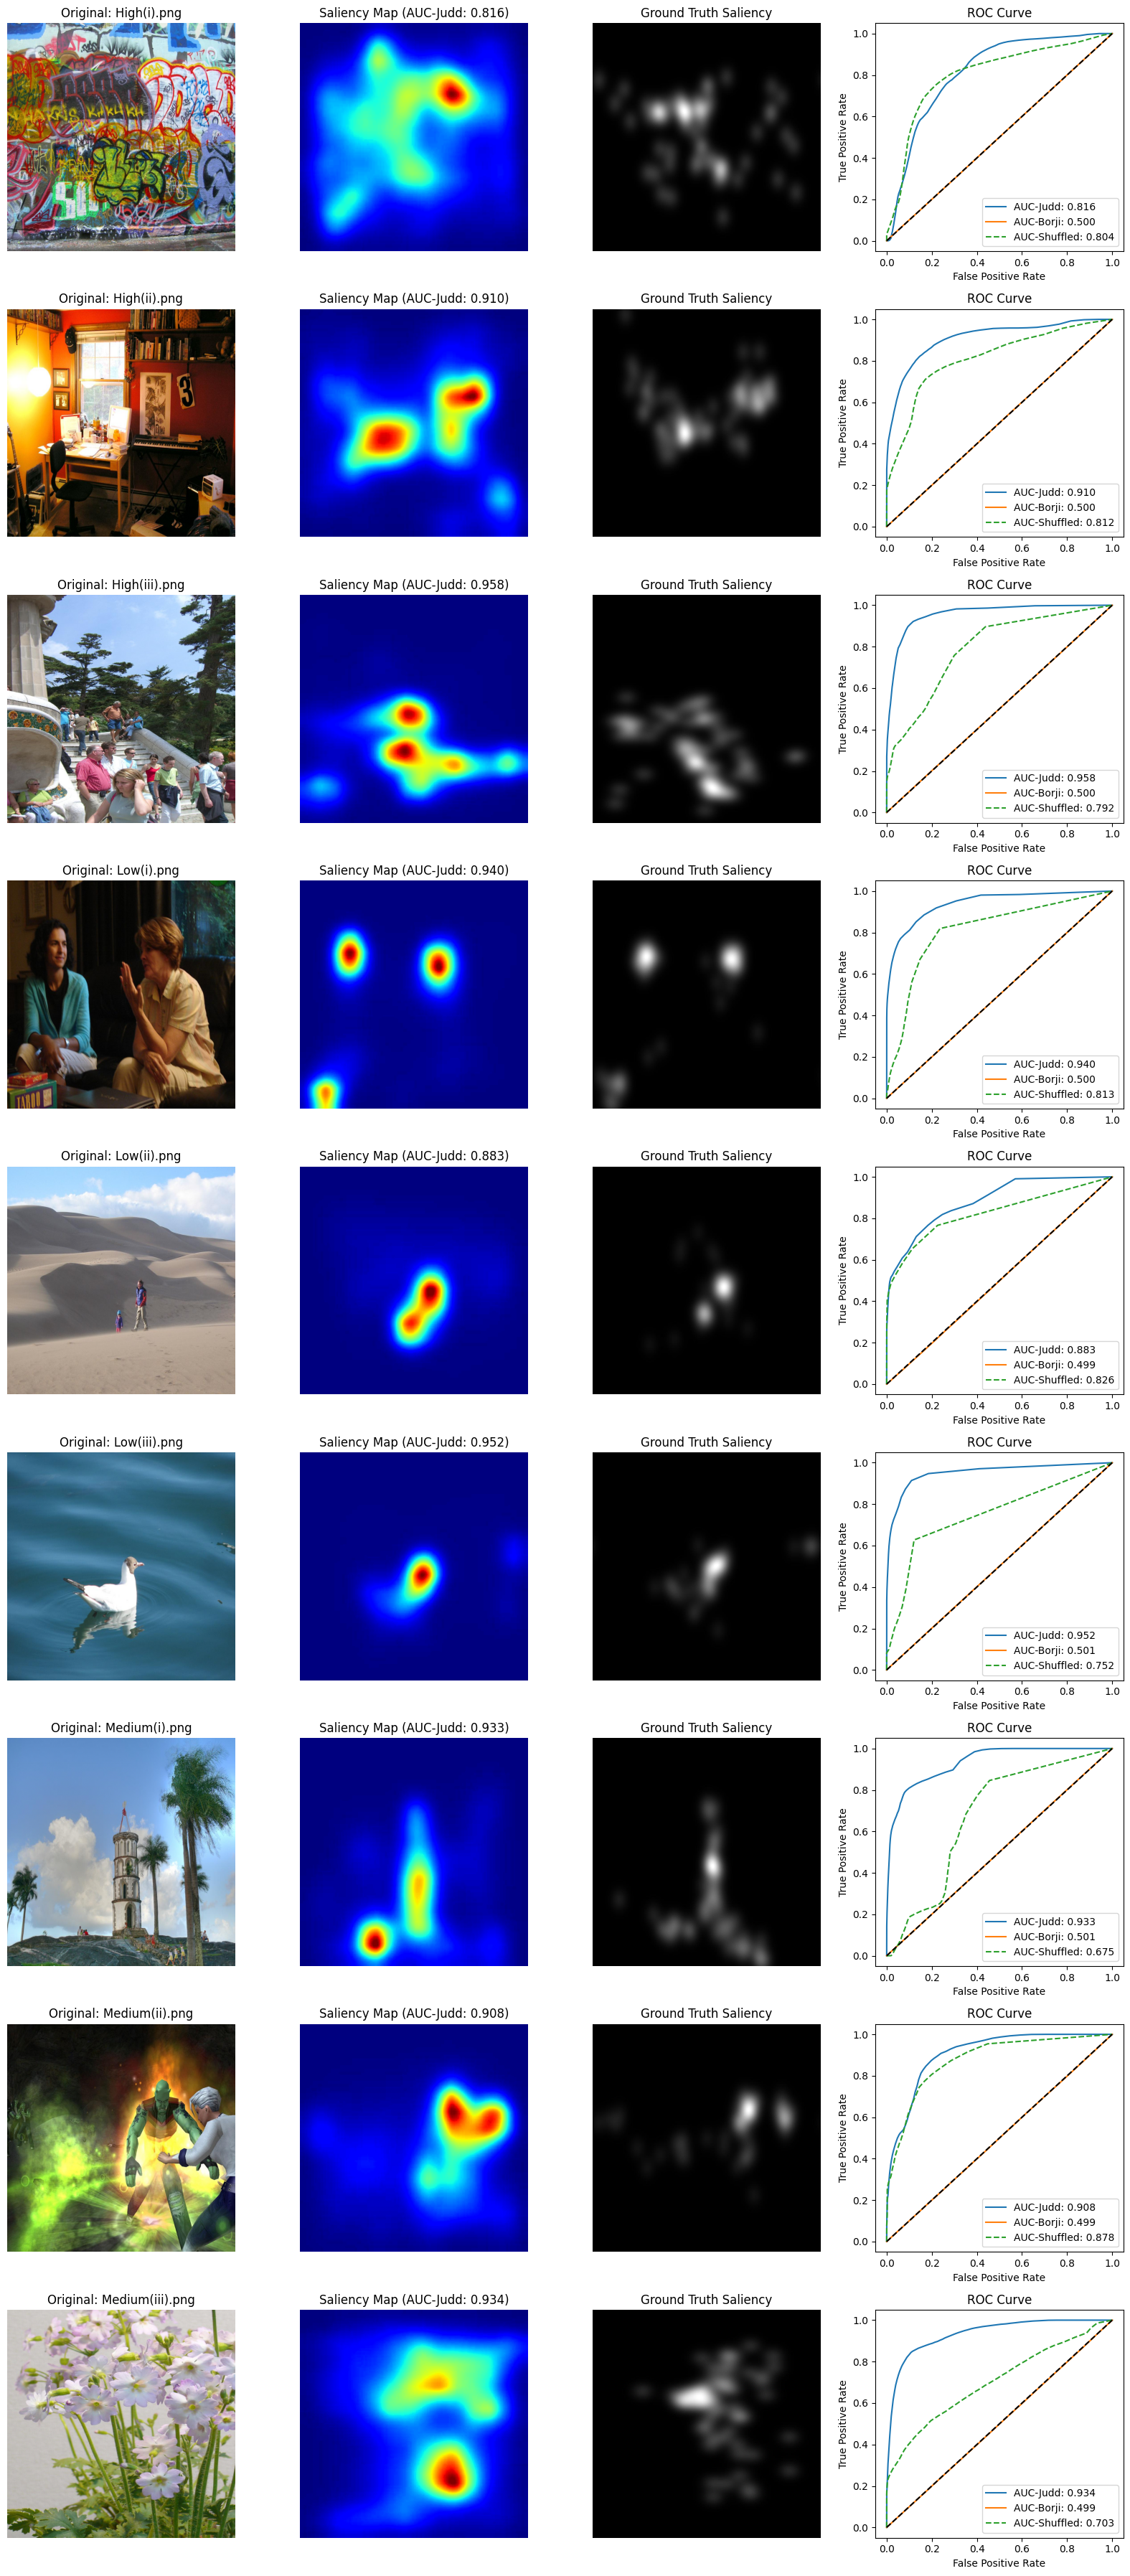

In [8]:
# Visualization of stimuli, ground truth saliency maps, and predicted maps with auc scores.
num_images = len(file_names)
if num_images == 0:
    raise ValueError("No valid images to display!")

fig, axs = plt.subplots(nrows=num_images, ncols=4, figsize=(16, 4 * num_images))
axs = np.atleast_2d(axs)

for i, (filename, auc_judd, auc_borji, auc_shuffled, rocs) in enumerate(results):
    axs[i, 0].imshow(raw_images[i])
    axs[i, 0].set_axis_off()
    axs[i, 0].set_title(f"Original: {filename}")
    
    axs[i, 1].imshow(pred_saliency_maps[i], cmap="jet")
    axs[i, 1].set_axis_off()
    axs[i, 1].set_title(f"Saliency Map (AUC-Judd: {auc_judd:.3f})")
    
    axs[i, 2].imshow(gt_saliency_maps[i], cmap="gray")
    axs[i, 2].set_axis_off()
    axs[i, 2].set_title("Ground Truth Saliency")
    
    axs[i, 3].plot(rocs[0], rocs[1], label=f"AUC-Judd: {auc_judd:.3f}")
    axs[i, 3].plot(rocs[2], rocs[3], label=f"AUC-Borji: {auc_borji:.3f}")
    if rocs[4] is not None and rocs[5] is not None:
        axs[i, 3].plot(rocs[4], rocs[5], label=f"AUC-Shuffled: {auc_shuffled:.3f}", linestyle="dashed")
    axs[i, 3].plot([0, 1], [0, 1], "k--")
    axs[i, 3].set_xlabel("False Positive Rate")
    axs[i, 3].set_ylabel("True Positive Rate")
    axs[i, 3].set_title("ROC Curve")
    axs[i, 3].legend()

plt.tight_layout()
plt.show()